# Freddie Mac Mortgage Data

### Pipeline -Simple Logistic Regression

Thomas Butler (vra2cf), Andrej Erkelens (wsw3fa), Matt Suozzi (mds5dd)

labelCol: Delinquency Status

- Downsample and Split train and test data
- StringIndexer and OneHotEncoder for categorical features
- VectorAssembler of numerical features
- StandardScalar to scale features (if necessary)
- Cross-validation to train Random Forest
- Tune Hyperparameters on train data
- Evaluate on test: Accuracy, Confusion Matrix, ROC/AUROC


In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

from pyspark.sql.functions import *
import pandas as pd
import numpy as np

In [2]:
df = spark.read.parquet("/project/ds5559/Group_6_Housing/DS-5110-Final-Project/df_model_1.parquet")

In [3]:
#create binary variable for response
df = df.withColumn("label", when(df.Current_Loan_Delinquency_Status_Cat == "Past_Due", 1.0).\
                             when(df.Current_Loan_Delinquency_Status_Cat == "Deliquent",1.0).\
                            when(df.Current_Loan_Delinquency_Status_Cat == "0",0.0))

In [4]:
#Get all columns that need to be scaled.
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["Original_Interest_Rate"],
    outputCol="features_temp")

In [5]:
#Scale data
from pyspark.ml.feature import MaxAbsScaler

scaler = MaxAbsScaler(inputCol="features_temp", outputCol="scaledFeatures")

In [6]:
#Set up pipeline
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[assembler, scaler])

In [7]:
#transform data
model1 = pipeline.fit(df)
df = model1.transform(df)

In [8]:
#Split data
train_test = [0.5, 0.5]
train_data, test_data = df.randomSplit(train_test, 314)

#Downsample the dataframe by the label class 
#take fraction of label 0 so counts of label 1 ~= label 0

#frac = below code just hardencoding it to make it faster. Original code is commented out.
#frac = train_data.filter(train_data.label == 1).count()/train_data.filter(train_data.label == 0).count()
frac = 0.06243591176833405

train_data = train_data.sampleBy("label", fractions={0: frac, 1: 1}, seed=314)
train_data.cache()
train_data.groupBy("label").count().show()

+-----+------+
|label| count|
+-----+------+
|  0.0|129217|
|  1.0|129571|
+-----+------+



In [9]:
#Run logistic regression on train data
from pyspark.ml.classification import LogisticRegression

log_reg = LogisticRegression(labelCol = "label", featuresCol = "scaledFeatures", maxIter = 10, regParam = 0.3, elasticNetParam=0.8, family="binomial")

In [10]:
#set up CV model
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
#reference: https://medium.com/swlh/logistic-regression-with-pyspark-60295d41221

#Create Grid for CV
pGrid = (ParamGridBuilder()
        .addGrid(log_reg.regParam, [0.01, 0.5, 2.0])
        .addGrid(log_reg.elasticNetParam, [0.0, 0.5, 1.0])
        .addGrid(log_reg.maxIter, [1, 5, 10])
        .build())

#log reg CV model
lr_cv = CrossValidator(estimator = log_reg, estimatorParamMaps = pGrid, evaluator = BinaryClassificationEvaluator(), numFolds=5).setParallelism(2)

In [11]:
#run model
model = lr_cv.fit(train_data)

In [12]:
#Run model on test data
pred = model.transform(test_data)

#Best AROC
print('Best Test AUROC: ', BinaryClassificationEvaluator().evaluate(pred))

Best Test AUROC:  0.6829182258787415


In [13]:
#Best Parameters
#ref: https://medium.com/swlh/logistic-regression-with-pyspark-60295d41221
bestModel = model.bestModel

print("regParam: " + str(bestModel._java_obj.getRegParam()))
print("elasticNetParam: " + str(bestModel._java_obj.getElasticNetParam()))
print("maxIter: " + str(bestModel._java_obj.getMaxIter()))

regParam: 0.5
elasticNetParam: 0.0
maxIter: 10


In [14]:
#get best threshold by F1 score
F_measure = bestModel.summary.fMeasureByThreshold

#determine best Threshold by F score because we care more about false positives and false negatives.
#ref: https://spark.apache.org/docs/2.1.0/ml-classification-regression.html

maxF_measure = F_measure.groupBy().max('F-Measure').select('max(F-Measure)').head()
best_thres = F_measure.where(F_measure["F-Measure"] == maxF_measure['max(F-Measure)']).select('threshold').head()["threshold"]
print("Best F-Measure: " + str(maxF_measure[0]))
print("Best Threshold: " + str(best_thres))

Best F-Measure: 0.689981227419418
Best Threshold: 0.4617674384389655


In [15]:
print("The Intercept is " + str(bestModel.intercept))

The Intercept is -1.052123959081069


In [16]:
print("Order of Coefficients is Original_Interest_Rate.")
coefficients = bestModel.coefficients
coefficients

Order of Coefficients is Original_Interest_Rate.


DenseVector([1.9451])

In [31]:
x1 = []
y1 = []

In [32]:
from pyspark.mllib.evaluation import MulticlassMetrics
temp = pred.select("probability", "label")

In [33]:
def round_thres(num):
    if num >= 0.35:
        return 1.0
    else:
        return 0.0
                       
predsAndLabels = temp.rdd.map(lambda p: (round_thres(float(p.probability[1])),p.label))

metrics = MulticlassMetrics(predsAndLabels)

print('model accuracy: ' + str(metrics.accuracy))

print('model precision: ' + str(metrics.precision(1.0)))

print('model F-Score: ' + str(metrics.fMeasure(0.0, 1.0)))

x1.append(metrics.falsePositiveRate(1.0))
y1.append(metrics.truePositiveRate(1.0))

con_matrix = metrics.confusionMatrix().toArray()
print(con_matrix)

#Maximize Negative Predictive value NPV
NPV = con_matrix[0][0]/(con_matrix[0][0]+con_matrix[1][0])
print("Negative Predictive Value: " + str(NPV))

model accuracy: 0.058678224972703426
model precision: 0.058678224972703426
model F-Score: 0.0
[[      0. 2076858.]
 [      0.  129463.]]
Negative Predictive Value: nan


/opt/conda/lib/python3.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in double_scalars


In [34]:
#Evaluate Accuracy and Confusion Matrix on test matrix
def round_thres(num):
    if num >= best_thres:
        return 1.0
    else:
        return 0.0
                       
predsAndLabels = temp.rdd.map(lambda p: (round_thres(float(p.probability[1])),p.label))

metrics = MulticlassMetrics(predsAndLabels)

print('model accuracy: ' + str(metrics.accuracy))

print('model precision: ' + str(metrics.precision(1.0)))

print('model F-Score: ' + str(metrics.fMeasure(0.0, 1.0)))

x1.append(metrics.falsePositiveRate(1.0))
y1.append(metrics.truePositiveRate(1.0))

con_matrix = metrics.confusionMatrix().toArray()
print(con_matrix)

#Maximize Negative Predictive value NPV
NPV = con_matrix[0][0]/(con_matrix[0][0]+con_matrix[1][0])
print("Negative Predictive Value: " + str(NPV))

model accuracy: 0.3557705338434434
model precision: 0.07526412965432352
model F-Score: 0.48544365545815404
[[ 670479. 1406379.]
 [  14998.  114465.]]
Negative Predictive Value: 0.9781203453945209


In [35]:
def round_thres(num):
    if num >= 0.5:
        return 1.0
    else:
        return 0.0

predsAndLabels = temp.rdd.map(lambda p: (round_thres(float(p.probability[1])),p.label))

metrics = MulticlassMetrics(predsAndLabels)

print('model accuracy: ' + str(metrics.accuracy))

print('model precision: ' + str(metrics.precision(1.0)))

print('model F-Score: ' + str(metrics.fMeasure(0.0, 1.0)))

x1.append(metrics.falsePositiveRate(1.0))
y1.append(metrics.truePositiveRate(1.0))

con_matrix = metrics.confusionMatrix().toArray()
print(con_matrix)

#Maximize Negative Predictive value NPV
NPV = con_matrix[0][0]/(con_matrix[0][0]+con_matrix[1][0])
print("Negative Predictive Value: " + str(NPV))

model accuracy: 0.6537752212846635
model precision: 0.10032507213325438
model F-Score: 0.7810915518486985
[[1362813.  714045.]
 [  49838.   79625.]]
Negative Predictive Value: 0.9647202316778879


In [36]:
def round_thres(num):
    if num >= 0.65:
        return 1.0
    else:
        return 0.0

predsAndLabels = temp.rdd.map(lambda p: (round_thres(float(p.probability[1])),p.label))

metrics = MulticlassMetrics(predsAndLabels)

print('model accuracy: ' + str(metrics.accuracy))

print('model precision: ' + str(metrics.precision(1.0)))

print('model F-Score: ' + str(metrics.fMeasure(0.0, 1.0)))

x1.append(metrics.falsePositiveRate(1.0))
y1.append(metrics.truePositiveRate(1.0))

con_matrix = metrics.confusionMatrix().toArray()
print(con_matrix)

#Maximize Negative Predictive value NPV
NPV = con_matrix[0][0]/(con_matrix[0][0]+con_matrix[1][0])
print("Negative Predictive Value: " + str(NPV))

model accuracy: 0.9407851350732735
model precision: 0.21121951219512194
model F-Score: 0.9694830499151041
[[2.075241e+06 1.617000e+03]
 [1.290300e+05 4.330000e+02]]
Negative Predictive Value: 0.9414636403600102


In [37]:
def round_thres(num):
    if num >= 0.75:
        return 1.0
    else:
        return 0.0

predsAndLabels = temp.rdd.map(lambda p: (round_thres(float(p.probability[1])),p.label))

metrics = MulticlassMetrics(predsAndLabels)

print('model accuracy: ' + str(metrics.accuracy))

print('model precision: ' + str(metrics.precision(1.0)))

print('model F-Score: ' + str(metrics.fMeasure(0.0, 1.0)))

x1.append(metrics.falsePositiveRate(1.0))
y1.append(metrics.truePositiveRate(1.0))

con_matrix = metrics.confusionMatrix().toArray()
print(con_matrix)

#Maximize Negative Predictive value NPV
NPV = con_matrix[0][0]/(con_matrix[0][0]+con_matrix[1][0])
print("Negative Predictive Value: " + str(NPV))

model accuracy: 0.9413217750272965
model precision: 0.0
model F-Score: 0.9697740860234887
[[2076858.       0.]
 [ 129463.       0.]]
Negative Predictive Value: 0.9413217750272965


In [38]:
def round_thres(num):
    return 0.0

predsAndLabels = temp.rdd.map(lambda p: (round_thres(float(p.probability[1])),p.label))

metrics = MulticlassMetrics(predsAndLabels)

print('model accuracy: ' + str(metrics.accuracy))

print('model precision: ' + str(metrics.precision(1.0)))

print('model F-Score: ' + str(metrics.fMeasure(0.0, 1.0)))

con_matrix = metrics.confusionMatrix().toArray()
print(con_matrix)

#Maximize Negative Predictive value NPV
NPV = con_matrix[0][0]/(con_matrix[0][0]+con_matrix[1][0])
print("Negative Predictive Value: " + str(NPV))

model accuracy: 0.9413217750272965
model precision: 0.0
model F-Score: 0.9697740860234887
[[2076858.       0.]
 [ 129463.       0.]]
Negative Predictive Value: 0.9413217750272965


In [39]:
x1.append(0.0)
y1.append(0.0)
print(x1)
print(y1)

[1.0, 0.6771666623331976, 0.34381021716458227, 0.0007785799510606888, 0.0, 0.0]
[1.0, 0.8841522288221345, 0.6150405907479357, 0.003344584939326294, 0.0, 0.0]


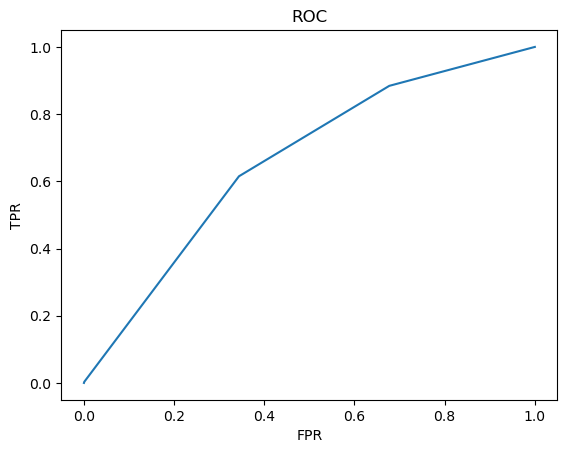

In [40]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(x1, y1)
plt.show()

In [41]:
#ref: https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve
#ROC Curve using Scala, Not my code, put in as a sanity check to make sure ROC Curve is close to right.

from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [42]:
temp = pred.select("probability", "label")

predsAndLabels = temp.rdd.map(lambda p: (float(p.probability[1]),p.label))

points = CurveMetrics(predsAndLabels).get_curve('roc')

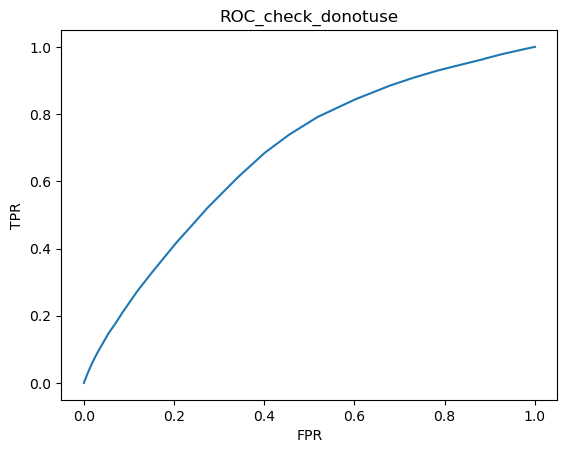

In [43]:
plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title("ROC_check_donotuse")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.plot(x_val, y_val)
plt.show()